# Regression:

This notebook contains an implementation with all necessary steps to perform dual annealing regression using the trained CVAE. 

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import torch
import pandas as pd
import nn_tools as nt
import os
import json
import glob
from scipy.interpolate import griddata
import random
import torch.nn as nn
from tqdm import tqdm

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print("Cuda found and in use")

elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
    print('MPS Found and in use')
else:
    print("No GPU found; Performance will be poor")

MPS Found and in use


## Model Passthrough Functions

These are important to conduct the model passthrough for the trial evaluations run in the dual annealing algorithm on scipy. These are integrated into the objective function (to be minimised by the algo) seen later.

In [66]:
def model_outputs_linear(wilson, model_linear):
    w1,w2  = wilson
    input = torch.Tensor(np.array([[w1, w2]])).to(DEVICE)
    
    # =-=-= Linear Method of Reading Outputs =-=-=
    outputs = model_linear(input)
    outputs = outputs.to('cpu')
    
    return outputs.detach().numpy()

def model_outputs_CVAE(wilson, model_cvae):
    w1, w2 = wilson
    input = torch.Tensor(np.array([[w1, w2]])).to(DEVICE)

    # =-=-= CVAE Method of Reading Outputs =-=-=
    outputs = model_cvae.generate_histogram(input)
    outputs = outputs.to('cpu')
    
    return outputs.detach().numpy()

# Objective Functions

In [67]:
def MSE_Linear(wilson):
    predicted_outputs = model_outputs_linear(wilson, model_lin=model_linear)
    MSE = np.mean((predicted_outputs - eos_bin_heights) ** 2)
    return MSE

def MSE_CVAE(wilson):
    predicted_outputs = model_outputs_CVAE(wilson, model_cvae=model_cvae)
    MSE = np.mean((predicted_outputs - eos_bin_heights)**2)
    return MSE

def actual_wilson(json_config):
    with open(json_config, 'r') as f:
        return json.load(f)

### Dual Annealing - Single Evaluation - Linear Network

In [4]:
import torch
import numpy as np
import pandas as pd
from scipy.optimize import dual_annealing
import nn_tools as nt

# Paths
nn_state_path = 'nn_outputs/wilson_csr/mu_4d.pth'
data_path = 'nn_outputs/wilson_csr_fit/normal_targets/model_WET_mu_6.csv'
config_path = 'nn_outputs/wilson_csr_fit/normal_inputs/model_WET_mu_6.json'

# =-=-= Read in Reference Bin-Heights and Wilson Coefficients =-=-=
eos_df = pd.read_csv(data_path, index_col=0)
eos_bin_heights = eos_df['bin_height'].values

def actual_wilson(config_path):
    with open(config_path, 'r') as json_file:
        data = json.load(json_file)
    return data  # Adjust this based on the actual structure of your JSON

true_wc = actual_wilson(config_path)
wcs = np.array(list(true_wc.values()))

# =-=-= Load in the trained neural network =-=-=
model_linear = nt.base_model(input_dim=len(wcs), output_dim=10000).to(DEVICE)
model_linear.load_state_dict(torch.load(nn_state_path, map_location=DEVICE))
model_linear.eval()

def model_outputs_linear(wilson, model_lin=model_linear):
    input_tensor = torch.Tensor(np.array([wilson])).to(DEVICE)  # Ensure input is 2D
    outputs = model_lin(input_tensor)
    outputs = outputs.to('cpu')
    return outputs.detach().numpy()

# Define the MSE function for dual annealing
def MSE_Linear(wilson):
    pred_bin_heights = model_outputs_linear(wilson)
    mse = np.mean((pred_bin_heights - eos_bin_heights) ** 2)
    return mse

# =-=-= Run the Dual Annealing Algorithm =-=-=
bounds = [(0, 1)] * len(wcs)  # Adjust bounds based on the number of Wilson coefficients
result = dual_annealing(MSE_Linear, bounds, maxfun=500).x

print("Optimized Wilson Coefficients:", result)
print("Actual Wilson Coefficients:", actual_wilson(config_path))

/var/folders/cr/w27s1x1d3xd8n4jvj7r7dq800000gp/T/ipykernel_24720/460004472.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_linear.load_state_dict(torch.load(nn_st

Optimized Wilson Coefficients: [0.900254]
Actual Wilson Coefficients: {'wc_0': 0.0}


### Dual Annealing - Single Evaluation - CVAE Network

In [5]:
nn_state_path = 'nn_outputs/wilson_csr_cvr/CVAE_mu_4d.pth'
data_path = 'nn_outputs/wilson_csr_cvr/normal_targets/model_WET_mu_768.csv'
config_path = 'nn_outputs/wilson_csr_cvr/normal_inputs/model_WET_mu_768.json'

# =-=-= Read in Reference Bin-Heights and Wilson Coefficients =-=-=
eos_df = pd.read_csv(data_path, index_col=0)
eos_bin_heights = eos_df['bin_height'].values

wcs = actual_wilson(config_path)

# =-=-= Load in the trained neural network =-=-=
model_cvae = nt.CVAE(input_shape=len(wcs), output_shape=10000, latent_dim=40).to(DEVICE)

model_cvae.load_state_dict(torch.load(nn_state_path, map_location=DEVICE, weights_only=False))
model_cvae.to(DEVICE)
model_cvae.eval()

# =-=-= Run the Dual Annealing Algorithm =-=-=
bounds = [(0,1),(0,1)]

result = dual_annealing(MSE_CVAE, bounds, maxfun=5e2).x
actual_wc = actual_wilson(config_path)

### Dual Annealing - Multiple Evaluation 

#### Function Evaluation

In [17]:
def evaluate_model(nn_state_path, eos_csv_path, inputs_json_path, 
                   
                   device, mtype):
    """
    Evaluates the model by calculating the Mean Squared Error (MSE) for a range of Wilson Coefficients (WC)
    and plots the variation of MSE with respect to WC.

    Parameters
    ----------
    nn_state_path : str
        Path to the saved model state dictionary.
    eos_csv_path : str
        Path to the CSV file containing the theoretical data (bin heights).
    inputs_json_path : str
        Path to the JSON file containing the input parameters (WC).
    number_bins : int
        Number of bins used in the model.
    device : torch.device
        The device to run the model on (e.g., 'cpu' or 'cuda').
    wc_range_steps : int, optional
        Number of steps in the WC range (default is 1000).

    Returns
    -------
    float
        The predicted Wilson Coefficient with the minimum MSE.
    float
        The actual Wilson Coefficient from the input JSON file.
    np.ndarray
        The array of MSE values for each WC in the range.
    """
    
    # ---- Bayesian Optimised CVAE ----
    

    # ---- Load In Objective Data to fit to ----
    eos_df = pd.read_csv(eos_csv_path, index_col=0)
    
    with open(inputs_json_path, 'r') as f:
        inputs = json.load(f)

    parameters = np.array(list(inputs.values()))

    eos_bin_heights = eos_df['bin_height'].values

    if mtype.lower() == 'linear':
        # =-=-= Model Passthrough Function Initialisation =-=-=
        def model_outputs_linear(wilson, model_lin, dim=len(parameters)):
            if dim == 2:
                w1,w2  = wilson
                input = torch.Tensor(np.array([[w1, w2]])).to(DEVICE)

            else:
                input = torch.Tensor(np.array([wilson])).to(DEVICE)

            # =-=-= Linear Method of Reading Outputs =-=-=
            outputs = model_lin(input)
            outputs = outputs.to('cpu')

            return outputs.detach().numpy()

        # ---- Load the model and its state ----
        model_linear = nt.base_model(input_dim=len(parameters), output_dim=10000).to(DEVICE)

        model_linear.load_state_dict(torch.load(nn_state_path, map_location=device, weights_only=False))
        model_linear.to(device)
        model_linear.eval()

        # =-=-= Define the Loss Function to Minimise =-=-=
        def MSE_Linear(wilson):
            predicted_outputs = model_outputs_linear(wilson, model_lin=model_linear)
            MSE = np.mean((predicted_outputs - eos_bin_heights) ** 2)
            return MSE
        
        # ---- Run the Dual Annealing Algo ----
        bounds = [(0,1)] * len(parameters)
        result = dual_annealing(MSE_Linear, bounds, maxfun=5e2).x
        
    else:
        # =-=-= Model Passthrough Function Initialisation =-=-=
        def model_outputs_CVAE(wilson, model_CVAE, dim=len(parameters)):
            if dim == 2:
                w1,w2  = wilson
                input = torch.Tensor(np.array([[w1, w2]])).to(DEVICE)

            else:
                w1 = wilson
                input = torch.Tensor(np.array([[w1]])).to(DEVICE)

            # =-=-= CVAE Method of Reading Outputs =-=-=
            outputs = model_CVAE.generate_histogram(input)
            outputs = outputs.to('cpu')
            
            return outputs.detach().numpy()

        # ---- Load the model and its state ----
        split = nn_state_path.split('/')
        normal_path = os.path.join(split[0], split[1])

        cfg =  nt.BO_CVAE(normal_path, [parameters], [[0] * 10000])

        model_cvae = nt.CVAE_Opt(input_shape=cfg['dim'][0], output_shape=cfg['dim'][1], latent_dim=cfg['latent_dim'], encoder_layers=cfg['encoder'], decoder_layers=cfg['decoder'],
                   dropout_enc=cfg['encoder_drop'], dropout_dec=cfg['decoder_drop'])
        
        model_cvae.load_state_dict(torch.load(nn_state_path, map_location=device, weights_only=False))
        model_cvae.to(device)
        model_cvae.eval()

        # =-=-= Define the Loss Function to Minimise =-=-=
        def MSE_CVAE(wilson):
            predicted_outputs = model_outputs_CVAE(wilson, model_CVAE=model_cvae)
            MSE = np.mean((predicted_outputs - eos_bin_heights)**2)
            return MSE

        # ---- Run the Dual Annealing Algo ----
        bounds = [(0,1)] * len(parameters)

        result = dual_annealing(MSE_CVAE, bounds, maxfun=5e2).x

    return result, parameters

def wilson_accuracy(nn_state_path, data_path, device, mtype, self=True):
    if self:
        files = glob.glob(os.path.join(data_path, 'model_outputs/*.csv'))
    
    else:
        files = glob.glob(os.path.join(data_path, 'normal_targets/*.csv'))

    filenames = [os.path.splitext(os.path.basename(file))[0] for file in files]

    first_prediction = []
    wcs_obj = []

    for f in tqdm(filenames):
        event_data = data_path + f'/normal_targets/{f}.csv'
        config_data = data_path + f'/normal_inputs/{f}.json'

        prediction, actual_wc = evaluate_model(nn_state_path, event_data, config_data, device, mtype)
        
        first_prediction.append(prediction)
        wcs_obj.append(actual_wc)
        
    return np.array(first_prediction), np.array(wcs_obj)

#### Evaluation

In [ ]:
import importlib
import model_eval as me # Import your module
importlib.reload(me)  # Reload the module

csr_linear = 'nn_outputs/wilson_csr/mu_4d.pth'
csr_cvae = 'nn_outputs/wilson_tau_csr_cvr/CVAE_tau_4d.pth'

# pred_linear, obj_linear = wilson_accuracy(nn_state_path=csr_linear, data_path='nn_outputs/wilson_csr_fit', 
#                                   device=DEVICE, mtype='linear', self=False)

pred_cvae, obj_cvae = wilson_accuracy(nn_state_path=csr_cvae, data_path='nn_outputs/wilson_tau_csr_cvr', 
                                  device=DEVICE, mtype='CVAE', self=True)


100%|██████████| 392/392 [05:10<00:00,  1.26it/s]


## Visualisation

In [246]:
import numpy as np
import matplotlib.pyplot as plt

def QQ_Plot(prediction, objective):
    """
    Generates a QQ plot comparing predicted and actual Wilson coefficients,
    including reflections where necessary and fitting a trend line.

    Parameters
    ----------
    prediction : list or np.ndarray
        List or array of predicted Wilson coefficients.
    objective : list or np.ndarray
        List or array of actual Wilson coefficients.
    """
    plt.figure(figsize=(10, 10))

    # Convert lists to NumPy arrays
    objective = np.array(objective)
    prediction = np.array(prediction)

    # Identify conditions for reflection
    mask_1 = (objective < 0.5) & (prediction > 0.5) | (objective > 0.5) & (prediction < 0.5)

    # Create updated prediction lists with reflections where necessary
    pred_updated = np.where(mask_1, 1 - prediction, prediction)

    # Fit the new trend line using updated predictions
    vals = np.polyfit(objective, pred_updated, 1)
    func = np.poly1d(vals)

    # Plot original and reflected points together
    plt.figure(figsize=(10, 10))
    plt.plot(objective, pred_updated, 'o', label='Model Prediction', color='red')

    # Plot the new trend line
    plt.plot(sorted(objective), func(sorted(objective)), linestyle='dashed', label=f'Gradient: {vals[0]:.2f}, Offset {vals[1]:.2f}', color='black')

    # Plot the confidence interval as a shaded region
    # plt.fill_between(sorted(objective), sorted(lower_bound), sorted(upper_bound), color='gray', alpha=0.4, label='95% Confidence Interval')
    plt.rcParams["font.family"] = "Serif"
    plt.rcParams['font.size'] = 20
    # Labels and styling
    plt.xlabel('Actual Wilson Coefficient', fontsize=20)
    plt.ylabel('Predicted Wilson Coefficient', fontsize=20)
    plt.title('Model Performance Evaluation \n Tau Decay, cSR Prediction', fontsize=20)
    plt.legend()
    plt.grid()


<Figure size 1000x1000 with 0 Axes>

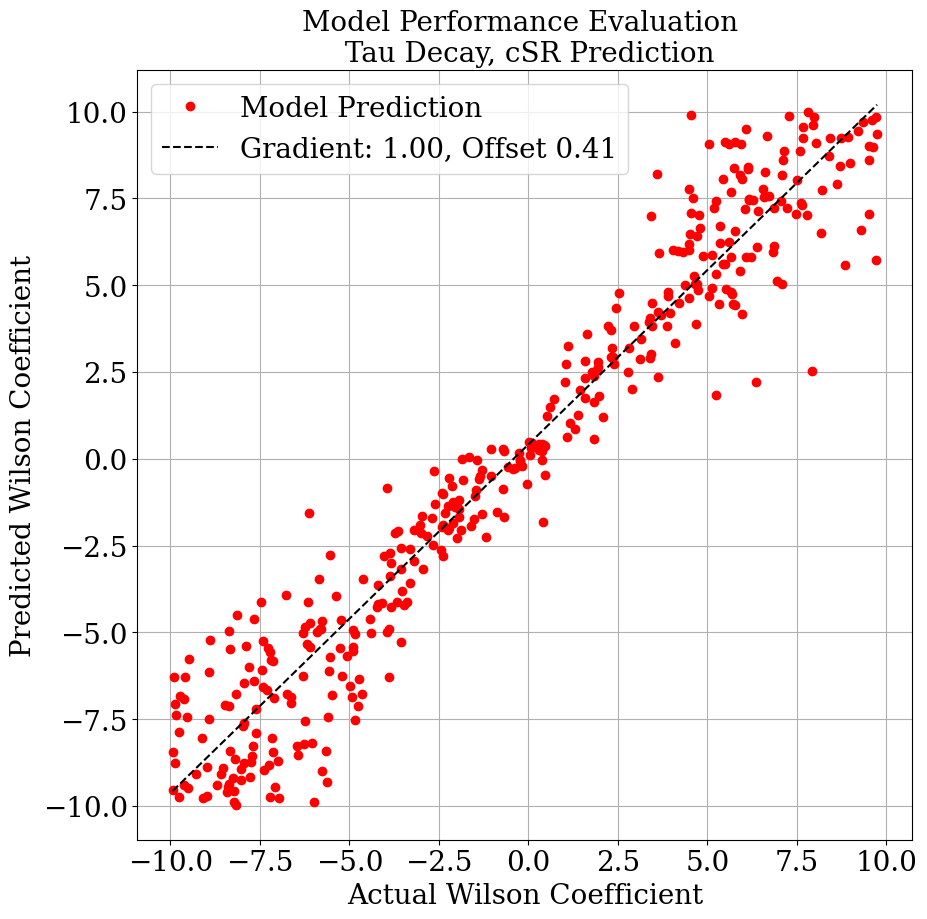

In [247]:
idx = 0

resc_pred = (pred_cvae * 20) - 10
resc_obj = (obj_cvae * 20) - 10

# QQ_Plot(pred_linear[:, idx], obj_linear[:, idx])
figure = QQ_Plot(resc_obj[:, idx], resc_pred[:, idx])



## Performance Metrics

In [249]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_predictions(prediction, objective):
    """
    Evaluates the accuracy of predictions compared to the objective values for each column separately.

    Parameters
    ----------
    pred_updated : np.ndarray
        Array of predicted values with shape (n, 2).
    objective : np.ndarray
        Array of actual values with shape (n, 2).

    Returns
    -------
    metrics : dict
        Dictionary containing the evaluation metrics for each column.
    """
    metrics = {}

    # Identify conditions for reflection
    mask_1 = (objective < 0.5) & (prediction > 0.5) | (objective > 0.5) & (prediction < 0.5)

    # Create updated prediction lists with reflections where necessary
    pred_updated = np.where(mask_1, 1 - prediction, prediction)

    for i in range(pred_updated.shape[1]):
        col_pred = pred_updated[:, i]
        col_obj = objective[:, i]

        mae = mean_absolute_error(col_obj, col_pred)
        mse = mean_squared_error(col_obj, col_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(col_obj, col_pred)

        metrics[f'Column {i+1}'] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R²': r2
        }

    return metrics

In [250]:
met = evaluate_predictions(resc_pred, resc_obj)

In [251]:
met

{'Column 1': {'MAE': 1.1962038110593884,
  'MSE': 2.461026250726496,
  'RMSE': 1.5687658368050013,
  'R²': 0.9304229815002079},
 'Column 2': {'MAE': 0.9050971119957576,
  'MSE': 1.4399766480148455,
  'RMSE': 1.1999902699667384,
  'R²': 0.9582961380316256}}

## Fit Outputs Histogram

In [ ]:
def plot_histogram_for_obj_value(obj, pred_1, target_value):
    # Convert lists to numpy arrays
    obj_array = np.array(obj)
    pred_1_array = np.array(pred_1)
    
    # Find indices where the target_value occurs in obj
    indices = np.where(obj_array == target_value)[0]
    
    # Extract associated values from pred_1
    associated_values = pred_1_array[indices]
    
    # Apply symmetry mirroring
    if target_value == 0.5:
        pass

    elif target_value < 0.5:
        associated_values = np.where(associated_values > 0.5, 1.0 - associated_values, associated_values)

    else:
        associated_values = np.where(associated_values < 0.5, 1.0 - associated_values, associated_values)
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(associated_values, bins=10, density=True, color='skyblue', edgecolor='black', label='Model Outputs')
    
    # Plot vertical line for the specified target_value
    plt.axvline(target_value, color='red', linestyle='dashed', linewidth=2, label=f'True WC (cSR): {target_value}')
    
    # Add grid, labels, and legend
    plt.grid(True)
    plt.xlabel('Predicted Values')
    plt.ylabel('Density')
    plt.title(f'Histogram of Model Outputs | Objective cSR Value: {target_value}')
    plt.legend()
    plt.xlim(0, 1.0)
    
    # Show plot
    plt.show()

In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from scipy.optimize import dual_annealing
import json
import os

split = csr_cvae.split('/')
normal_path = os.path.join(split[0], split[1])
cfg = nt.BO_CVAE(normal_path, [[1, 2]], [[0] * 10000])

model_cvae = nt.CVAE_Opt(input_shape=cfg['dim'][0], output_shape=cfg['dim'][1], latent_dim=cfg['latent_dim'], encoder_layers=cfg['encoder'], decoder_layers=cfg['decoder'],
            dropout_enc=cfg['encoder_drop'], dropout_dec=cfg['decoder_drop'])

model_cvae.load_state_dict(torch.load(csr_cvae, map_location=DEVICE, weights_only=False))
model_cvae.to(DEVICE)
model_cvae.eval()


def model_outputs_CVAE(wilson, model_cvae):
    w1, w2 = wilson
    input = torch.Tensor(np.array([[w1, w2]])).to(DEVICE)

    # =-=-= CVAE Method of Reading Outputs =-=-=
    outputs = model_cvae.generate_histogram(input)
    outputs = outputs.to('cpu')
    
    return outputs.detach().numpy()

csv_path = 'nn_outputs/wilson_tau_csr_cvr/normal_targets/model_WET_tau_8.csv'
json_path = 'nn_outputs/wilson_tau_csr_cvr/normal_inputs/model_WET_tau_8.json'

with open(json_path, 'r') as f:
    wilsons = json.load(f)

data = pd.read_csv(csv_path)
eos_bin_heights = data['bin_height'].values

checkpoints = []
def callback(x, f, context):
    checkpoints.append(x)

bounds = [(0,1)] * 2
result = dual_annealing(MSE_CVAE, bounds, maxfun=1e3, callback=callback).x

checkpoints = np.array(checkpoints) * 20 - 10

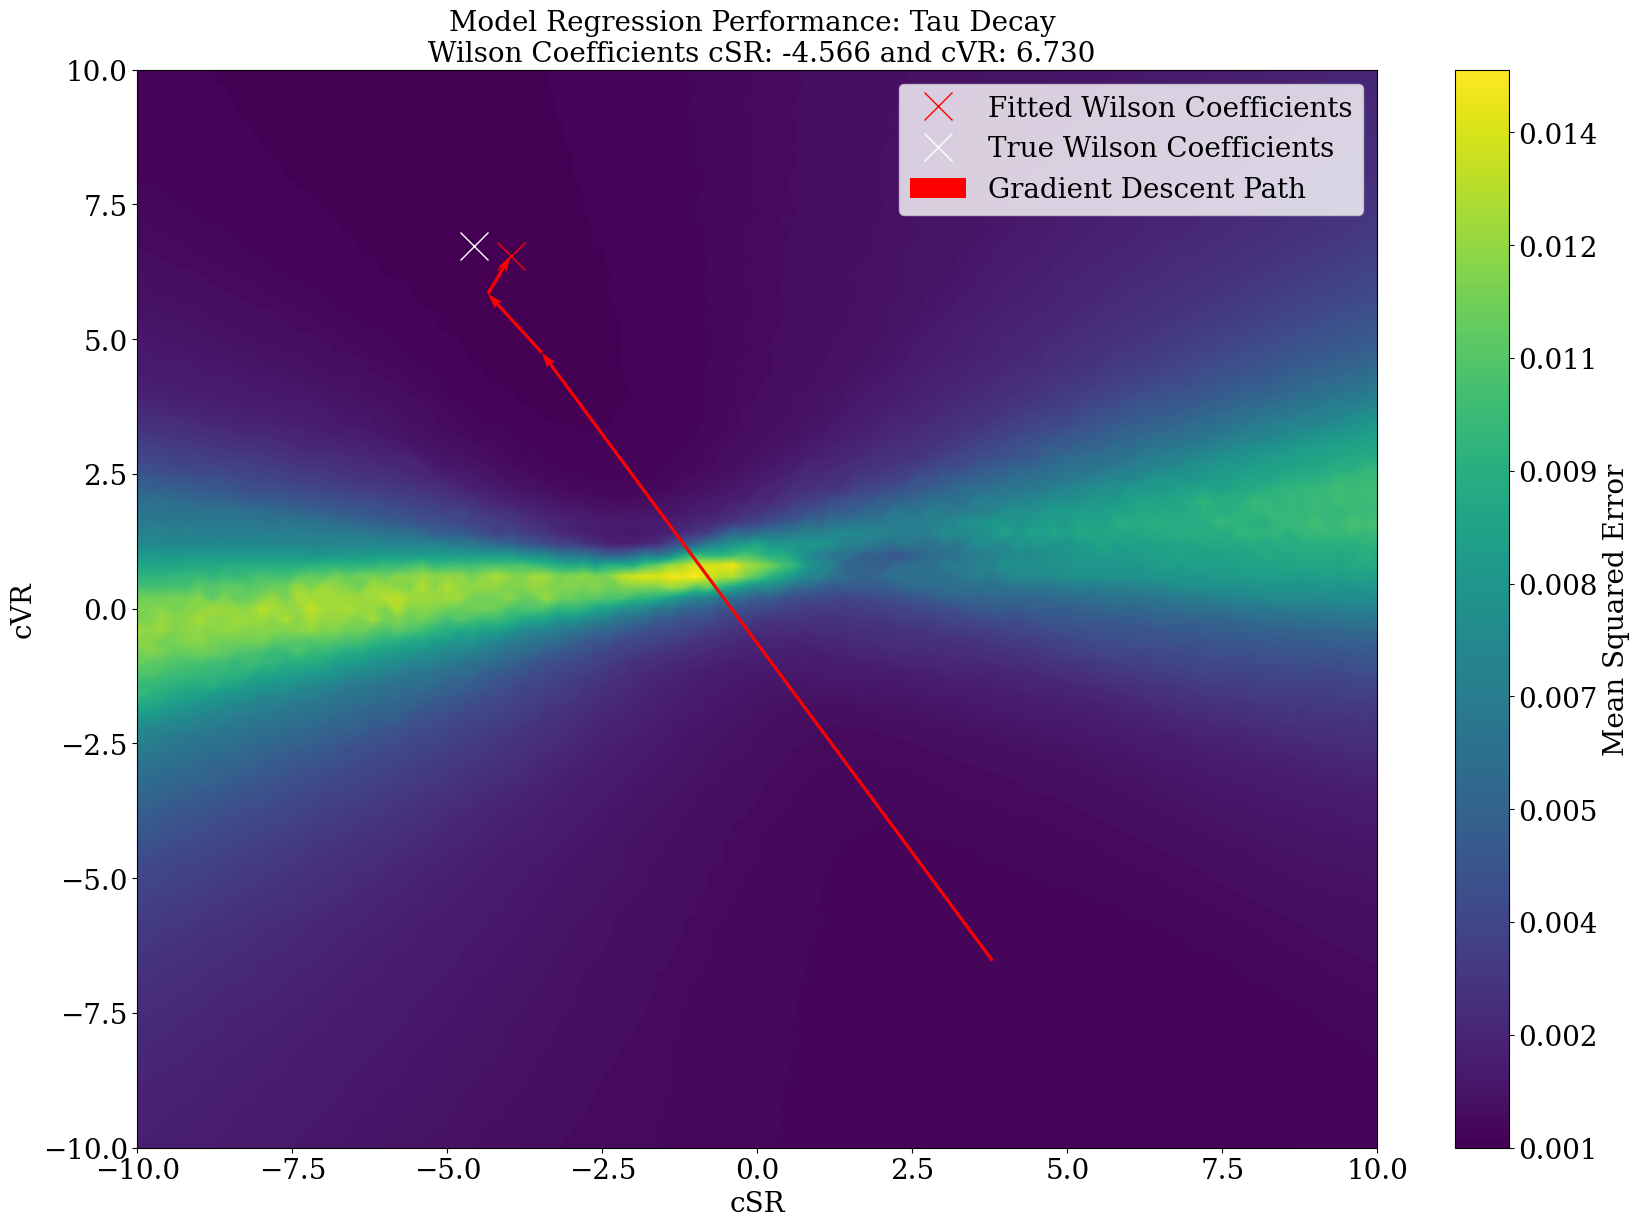

In [225]:
csr = np.linspace(0, 1, 101, endpoint=True)
cvr = np.linspace(0, 1, 101, endpoint=True)

csr_grid, cvr_grid = np.meshgrid(csr, cvr)
stack = np.stack([csr_grid.ravel(), cvr_grid.ravel()], axis=1)

wilson_tensor = torch.Tensor(stack).to(DEVICE)

def model_eval(csr, cvr, model):
    csr_grid, cvr_grid = np.meshgrid(csr, cvr)
    inputs = np.stack([csr_grid.ravel(), cvr_grid.ravel()], axis=1)
    inputs = torch.tensor(inputs, dtype=torch.float32).to(DEVICE)

    with torch.no_grad():
        outputs = model.generate_histogram(inputs)
        outputs = outputs.to('cpu').detach().numpy()

    return outputs

model_bins = model_eval(csr, cvr, model_cvae)
diff = np.mean((eos_bin_heights - model_bins)**2, axis=1)
mse_reshaped = diff.reshape(101, 101)

plt.rcParams["font.family"] = "Serif"
plt.rcParams['font.size'] = 20

plt.figure(figsize=(20, 14))
contour = plt.contourf((csr * 20) - 10, (cvr * 20) - 10, mse_reshaped, cmap='viridis', levels=200)
cbar = plt.colorbar(contour, format='%.3f')
cbar.set_label('Mean Squared Error')

plt.xlabel('cSR', fontsize=20)
plt.ylabel('cVR', fontsize=20)
plt.title(f'Model Regression Performance: Tau Decay \n Wilson Coefficients cSR: {list(wilsons.values())[0] * 20 - 10:.3f} and cVR: {list(wilsons.values())[1] * 20 - 10:.3f}', fontsize=20)

# Plot the path followed by the algorithm
plt.plot(result[0] * 20 - 10, result[1]* 20 - 10, 'x', markersize=20, color='red', label='Fitted Wilson Coefficients')
plt.plot(wilsons['wc_0'] * 20 - 10, wilsons['wc_1']* 20 - 10, 'x', markersize=20, color='white', label='True Wilson Coefficients')

# plt.plot(checkpoints[:, 0], checkpoints[:, 1], 'ro-', markersize=5, label='Path')
plt.quiver(checkpoints[:-1, 0], checkpoints[:-1, 1], 
           checkpoints[1:, 0] - checkpoints[:-1, 0], 
           checkpoints[1:, 1] - checkpoints[:-1, 1], 
           scale_units='xy', angles='xy', scale=1.0, width=0.0025, color='red', label='Gradient Descent Path')

plt.legend()
plt.show()